<a href="https://colab.research.google.com/github/data-tamer2410/ds-handwritten-digit-recognition/blob/main/handwritten_digit_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task.

Create a neural network that recognizes handwritten numbers.

# Creating a neural network.

The architecture of the neural network is presented in the following figure. It has one input layer, two hidden layers, and an output layer. The sigmoid will be used as the activation function in the hidden layers. On the output layer we use softmax.

## The architecture of the neural network.

<img src="http://cs231n.github.io/assets/nn1/neural_net2.jpeg" alt="nn" style="width: 400px;"/>


## About dataset MNIST.

We will study this neural network on the MNIST dataset. This dataset is a large number of images of handwritten digits of size $28 \times 28$ pixels. Each pixel takes a value from 0 to 255.

The dataset will be divided into training and test samples. At the same time, we will normalize all images so that the pixel value is between 0 and 1 by dividing the brightness of each pixel by 255.

In addition, the architecture of the neural network expects an input vector. In our case, each sample object is a matrix. What to do? In this task, we will "stretch" the $28 \times 28$ matrix, thus obtaining a vector consisting of 784 elements.

![MNIST Dataset](https://www.researchgate.net/profile/Steven-Young-5/publication/306056875/figure/fig1/AS:393921575309346@1470929630835/Example-images-from-the-MNIST-dataset.png)


More information about the dataset can be found [here](http://yann.lecun.com/exdb/mnist/).

## Data loading and preparation.

In [213]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import keras
import seaborn as sns
from sklearn.metrics import classification_report, f1_score, roc_auc_score
from sklearn.model_selection import StratifiedKFold

In [214]:
from keras.datasets import mnist

# Download the dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Convert integer pixels to float32 type
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)

# We convert 28x28 pixel matrices into a vector of 784 elements
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])

# Normalize pixel values
x_train, x_test = x_train / 255., x_test / 255.

# Let's shuffle the training data
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

## Network construction and training.

In [215]:
num_classes = 10 # total number of classes, in our case these are numbers from 0 to 9
num_features = 784 # number of attributes of the input vector 28 * 28 = 784

learning_rate = 0.001 # learning rate of the neural network
training_steps = 3000 # maximum number of epochs
batch_size = 256 # we will calculate the weights of the network not on the entire sample, but on its random subset of batch_size elements
display_step = 100 # every 100 iterations we will show the current value of the loss and accuracy function

n_hidden_1 = 128 # number of neurons of the 1st layer
n_hidden_2 = 256 # number of neurons of the 2nd layer

In [216]:
# Let's create a neural network

class DenseLayer(tf.Module):
    def __init__(self, in_features, out_features, name=None):
        super().__init__(name=name)
        self.w = tf.Variable(
            tf.random.normal([in_features, out_features]), name="w"
        )
        self.b = tf.Variable(tf.zeros([out_features]), name="b")

    def __call__(self, x, activation=0):
        y = tf.matmul(x, self.w) + self.b
        if activation != 0:
            return tf.nn.softmax(y)
        else:
            return tf.nn.sigmoid(y)

class NN(tf.Module):
  def __init__(self, name=None):
    super().__init__(name=name)
    # The first layer, which consists of 128 neurons
    self.layer_1 = DenseLayer(num_features,n_hidden_1,name='layer_1')
    # The second layer, which consists of 256 neurons
    self.layer_2 = DenseLayer(n_hidden_1,n_hidden_2,name='layer_2')
    # Output layer
    self.out_layer = DenseLayer(n_hidden_2,num_classes,name='out_layer')


  def __call__(self, x):
    # Data transmission through the first two layers and the output layer with activation function softmax
    x = self.layer_1(x)
    x = self.layer_2(x)
    x = self.out_layer(x,activation=1)
    return x

In [217]:
# In this case, it is convenient to take the cross-entropy as the error function
def cross_entropy(y_pred, y_true):
    # Encode label in one hot vector
    y_true = tf.one_hot(y_true, depth=num_classes)

    # Prediction value to avoid log(0) error.
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)

    # Calculation of cross-entropy
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred)))

# We use accuracy as a quality metric
def accuracy(y_pred, y_true):
    correct_pred = tf.equal(y_pred,y_true)
    return tf.reduce_mean(tf.cast(correct_pred,tf.float32))

In [218]:
# Neural network training function
def train(neural_net, input_x, output_y):
  # To adjust the weights of the network, we will use stochastic gradient descent
  optimizer = tf.optimizers.SGD(learning_rate)

  # Activation of automatic differentiation
  with tf.GradientTape() as g:
    pred = neural_net(input_x)
    loss = cross_entropy(pred, output_y)

    # We will get a list of optimized parameters
    w = neural_net.trainable_variables

    # Let's calculate the value of the gradient based on them
    gradients = g.gradient(loss,w)

    # We modify the parameters
    optimizer.apply_gradients(zip(gradients,w))

In [219]:
# Let's create an instance of a neural network
neural_net = NN(name="mnist")

# Network training

loss_history = []
accuracy_history = []

# In this cycle, we will train the neural network
for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
    # We update the weights of the neural network
    train(neural_net,batch_x,batch_y)

    if step % display_step == 0:
        y_pred_proba = neural_net(batch_x)
        y_pred = tf.argmax(y_pred_proba,axis=1,output_type=tf.int32)
        y_true = tf.cast(batch_y,tf.int32)

        loss_history.append(cross_entropy(y_pred_proba,y_true))
        accuracy_history.append(accuracy(y_pred,y_true))

## Assessment of network performance.

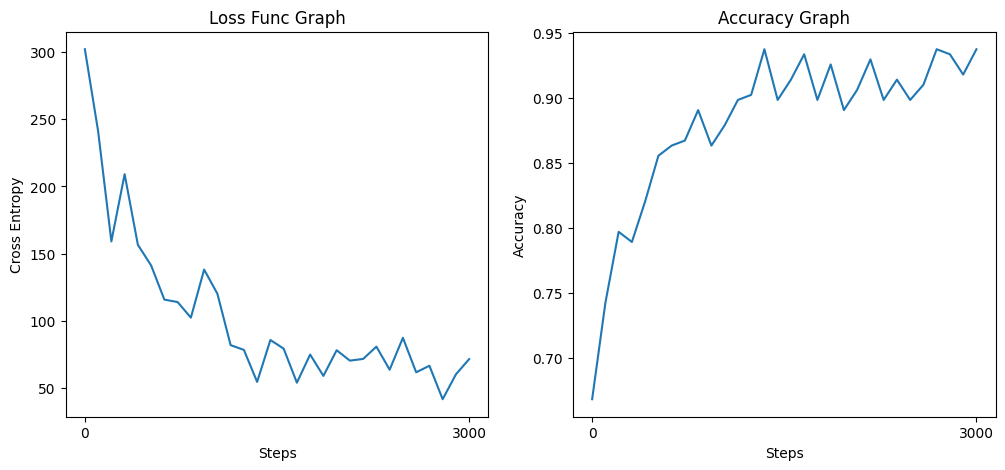

In [194]:
# Graphs of the dependence of the change in accuracy and losses on the step
# If done correctly, accuracy should increase and losses should decrease

import matplotlib.pyplot as plt

x = np.arange(len(loss_history))

fig, axs = plt.subplots(ncols=2,figsize=(12,5))

# Graph of the loss function
axs[0].plot(x,loss_history)

axs[0].set_title('Loss Func Graph')
axs[0].set_xlabel('Steps')
axs[0].set_ylabel('Cross Entropy')
axs[0].set_xticks((x[0],x[-1]),(0,training_steps))

# Accuracy graph
axs[1].plot(x,accuracy_history)

axs[1].set_title('Accuracy Graph')
axs[1].set_xlabel('Steps')
axs[1].set_ylabel('Accuracy')
axs[1].set_xticks((x[0],x[-1]),(0,training_steps))


plt.show()

In [195]:
# Accuracy of the trained neural network
y_pred_proba = neural_net(x_train)
y_pred = tf.argmax(y_pred_proba,axis=1)

print(f"Accuracy on train data: {accuracy(y_pred,y_train)}\n")

# Testing the model on test data
y_pred_proba = neural_net(x_test)
y_pred = tf.argmax(y_pred_proba,axis=1)

print(f"Classification report on test data:\n"
      f"{classification_report(y_test,y_pred)}")

Accuracy on train data: 0.9240666627883911

Classification report on test data:
              precision    recall  f1-score   support

           0       0.94      0.95      0.95       980
           1       0.97      0.98      0.98      1135
           2       0.90      0.88      0.89      1032
           3       0.89      0.88      0.88      1010
           4       0.91      0.89      0.90       982
           5       0.85      0.86      0.86       892
           6       0.92      0.94      0.93       958
           7       0.93      0.89      0.91      1028
           8       0.86      0.88      0.87       974
           9       0.86      0.89      0.87      1009

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



In [196]:
# Testing the trained neural network on 10 random images.
n_test_imgs = y_test.size

indices = np.random.choice(n_test_imgs,size=10,replace=False)
x_test_10 = x_test[indices]
y_test_10 = y_test[indices]

y_pred_proba = neural_net(x_test_10)
y_pred = tf.argmax(y_pred_proba,axis=1)

accuracy_score = accuracy(y_pred,y_test_10)
f1_weighted_score = f1_score(y_test_10,y_pred,average='weighted')

print(f"Test on random 10 test data:\n"
      f"Accuracy: {accuracy_score}\n"
      f"F1-weighted: {f1_weighted_score}")

Test on random 10 test data:
Accuracy: 0.800000011920929
F1-weighted: 0.8400000000000001


In [197]:
df = pd.DataFrame({'Prediction': y_pred,'True Target':y_test_10})
df

,Prediction,True Target
0,4,4
1,8,8
2,9,7
3,1,1
4,3,3
5,3,3
6,8,8
7,5,6
8,6,6
9,6,6


In [198]:
# Cross-validation
features = np.vstack((x_train,x_test))
targets = np.concatenate((y_train,y_test))

accuracy_list = []
f1_weighted_list = []
roc_auc_weighted_list = []

cv = StratifiedKFold(n_splits=10,shuffle=True,random_state=1)

for train_i, test_i in cv.split(features,targets):

    x_train_cv = tf.convert_to_tensor(features[train_i],dtype=tf.float32)
    y_train_cv = tf.convert_to_tensor(targets[train_i],dtype=tf.int32)

    x_test_cv = features[test_i]
    y_test_cv = tf.convert_to_tensor(targets[test_i],dtype=tf.int32)

    model = NN()

    train_cv = tf.data.Dataset.from_tensor_slices((x_train_cv,y_train_cv))
    train_cv = train_cv.repeat().batch(batch_size).prefetch(tf.data.AUTOTUNE)
    for batch_x, batch_y in train_cv.take(training_steps):
        train(model,batch_x,batch_y)

    y_pred_proba = model(x_test_cv)
    y_pred = tf.argmax(y_pred_proba,axis=1,output_type=tf.int32)

    accuracy_list.append(accuracy(y_pred,y_test_cv))
    f1_weighted_list.append(f1_score(y_test_cv,y_pred,average='weighted'))
    roc_auc_weighted_list.append(roc_auc_score(y_test_cv,y_pred_proba,multi_class='ovr',average='weighted'))

print(f"Results CV:\n"
      f"Accuracy: {np.mean(accuracy_list)}\n"
      f"F1-weighted: {np.mean(f1_weighted_list)}\n"
      f"ROC-AUC-weighted: {np.mean(roc_auc_weighted_list)}")

Results CV:
Accuracy: 0.8987285494804382
F1-weighted: 0.8986690733814392
ROC-AUC-weighted: 0.9919861132681692


## Conclusion.

### **English**

---

The model was successfully built, as evidenced by the effective decrease in the loss function and a significant increase in accuracy during training (this can be seen in the graphs). On the training data, the model achieved an **Accuracy** of **92.11%**, indicating good quality.

The model was tested using various quality metrics:
- **Precision**: high precision for all classes, especially for classes 1 (0.97), 7 (0.93), and 0 (0.94).
- **Recall**: also stable values, indicating that the model effectively recognizes most classes, particularly classes 1, 0 and 6.
- **F1-Score**: good values, especially for classes 0 (0.95) and 1 (0.98), confirming the balance between precision and recall.

Cross-validation showed that the model has an average **Accuracy** of around **89.87%**, which is a good indicator. **F1-weighted** is **0.89**, and **ROC-AUC-weighted** reaches **0.99**, indicating a high ability of the model to distinguish between classes.

Additionally, when tested on random 10 test data, the model showed an **Accuracy** of **80%** and **F1-weighted** of **0.84**, confirming the model's robustness on small samples.

Overall, it can be stated that the model correctly recognizes 8-9 digits out of 10, indicating a high level of quality.

### **Ukrainian**

---

Модель успішно побудована, про що свідчить ефективне зниження функції втрат і значне підвищення точності під час навчання (це можна побачити на графіках). На навчальних даних модель досягла **точності** **92.11%**, що свідчить про хорошу якість.

Модель була протестована за допомогою різних метрик якості:
- **Точність**: висока точність для всіх класів, особливо для класів 1 (0.97), 7 (0.93), і 0 (0.94)
- **Відповідність**: також стабільні значення, що свідчить про те, що модель ефективно розпізнає більшість класів, зокрема класи 1, 0 і 6.
- **F1-міра**: хороші значення, особливо для класу 0 (0.95) і 1 (0.98), що підтверджує баланс між точністю та відповідністю.

Крос-валідація показала, що модель має середню **точність** приблизно **89.87%**, що є хорошим показником. **F1-міра зважена** становить **0.89**, а **ROC-AUC зважений** досягає **0.99**, що свідчить про високу здатність моделі розрізняти між класами.

Крім того, при тестуванні на випадкових 10 тестових даних модель показала **точність** **80%** і **F1-міру зважену** **0.84**, що підтверджує надійність моделі на малих вибірках.

Загалом можна сказати, що модель правильно розпізнає 8-9 цифр з 10, що свідчить про високий рівень якості.
